In [43]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.quickplot as qplt

import numpy
import cf_units
from decimal import Decimal

In [44]:
%matplotlib inline

## Ocean heat content

In [45]:
#infile = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalMisc/yr/all/r1i1p4/energy-budget/latest/energy-budget_yr_CSIRO-Mk3-6-0_historicalMisc_r1i1p4_all.nc'
infile = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/piControl/yr/all/r1i1p1/energy-budget/latest/energy-budget_yr_CSIRO-Mk3-6-0_piControl_r1i1p1_all.nc'
ohc_cube = iris.load_cube(infile, 'ocean heat content sh sum')[80:236]

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [46]:
ohc_cube

<iris 'Cube' of ocean heat content sh sum / (J) (time: 156)>

In [47]:
def convert_to_seconds(time_axis):
    """Convert time axis units to seconds.
    Args:
      time_axis(iris.DimCoord)
    """

    old_units = str(time_axis.units)
    old_timestep = old_units.split(' ')[0]
    new_units = old_units.replace(old_timestep, 'seconds') 

    new_unit = cf_units.Unit(new_units, calendar=time_axis.units.calendar)  
    time_axis.convert_units(new_unit)

    return time_axis


def estimate_ohc_tendency_polyfit(ohc_cube, poly_type):
    """Estimate the OHC tendency by taking derivative of fitted polynomial.

    polyfit returns [c, b, a] corresponding to y = a + bx + cx^2 (quadratic)
    polyfit returns [d, c, b, a] corresponding to y = a + bx + cx^2 + dx^3 (cubic)

    """

    assert poly_type in ['quadratic', 'cubic']
    
    time_axis = convert_to_seconds(ohc_cube.coord('time')).points
    
    if poly_type == 'quadratic':
        coef_c, coef_b, coef_a = numpy.ma.polyfit(time_axis, ohc_cube.data, 2)
        ohc_polyfit_data = coef_a + (coef_b * time_axis) + (coef_c * time_axis**2)
        ohc_tendency_data = coef_b + 2 * coef_c * time_axis
    else:
        coef_d, coef_c, coef_b, coef_a = numpy.ma.polyfit(time_axis, ohc_cube.data, 3)
        ohc_polyfit_data = coef_a + (coef_b * time_axis) + (coef_c * time_axis**2) + (coef_d * time_axis**3)
        ohc_tendency_data = coef_b + (2 * coef_c * time_axis) + (3 * coef_d * time_axis**2)
    
    ohc_polyfit_cube = ohc_cube.copy()
    ohc_polyfit_cube.data = ohc_polyfit_data
    
    ohc_tendency_cube = ohc_cube.copy()
    ohc_tendency_cube.data = ohc_tendency_data
    ohc_tendency_cube.units = 'W'

    return ohc_polyfit_cube, ohc_tendency_cube

In [48]:
ohc_polyfit_cube, ohc_polyfit_tendency_cube = estimate_ohc_tendency_polyfit(ohc_cube, 'cubic')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


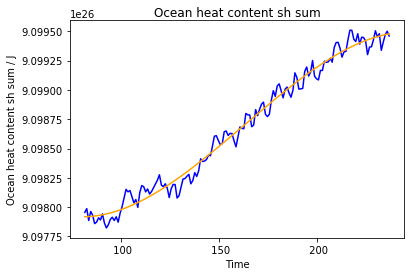

In [49]:
qplt.plot(ohc_cube, color='blue')
qplt.plot(ohc_polyfit_cube, color='orange')
plt.show()

## OHC tendency

#### dOHC/dt

In [50]:
def estimate_ohc_tendency_diff(ohc_cube):
    """Estimate the OHC tendency by calculating dOHC/dt"""
    
    #dohc = numpy.cumsum(ohc_cube.data - ohc_cube.data[0])
    dohc = ohc_cube.data - ohc_cube.data[0]
    
    dt = numpy.arange(0, 365.25 * len(dohc), 365.25) * 60 * 60 * 24
    #dt = len(dohc) * 365.25 * 60 * 60 * 24
    
    dohc_dt = dohc[1:] / dt[1:]
    
    dohc_dt_cube = ohc_cube[1:].copy()
    dohc_dt_cube.data = dohc_dt   
        
    units = str(dohc_dt_cube.units)
    dohc_dt_cube.units = units.replace('J', 'W')
    
    return dohc_dt_cube

In [51]:
ohc_diff_tendency_cube = estimate_ohc_tendency_diff(ohc_cube)

#### Fluxes

In [52]:
hfds_cube = iris.load_cube(infile, 'Downward Heat Flux at Sea Water Surface sh ocean sum')[80:236]
hfbasin_cube = iris.load_cube(infile, 'Northward Ocean Heat Transport sh ocean sum')[80:236]

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


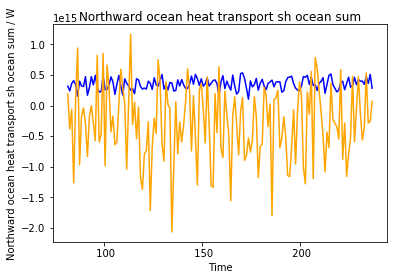

In [53]:
qplt.plot(hfds_cube, color='blue')
qplt.plot(hfbasin_cube, color='orange')
plt.show()

In [54]:
fluxes = hfds_cube + hfbasin_cube

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


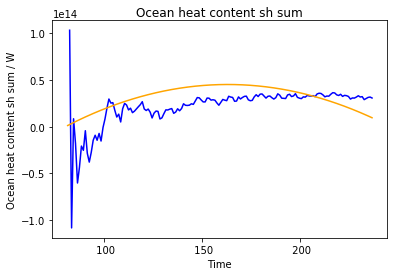

In [55]:
qplt.plot(ohc_diff_tendency_cube, color='blue')
qplt.plot(ohc_polyfit_tendency_cube, color='orange')
#qplt.plot(fluxes.rolling_window('time', iris.analysis.MEAN, 20), 'green')
plt.show()

## Trends

In [56]:
def _linear_trend(data, time_axis):
    """Calculate the linear trend.
    polyfit returns [a, b] corresponding to y = a + bx
    """    

    masked_flag = False

    if type(data) == numpy.ma.core.MaskedArray:
        if type(data.mask) == numpy.bool_:
            if data.mask:
                masked_flag = True
        elif data.mask[0]:
            masked_flag = True
            
    if masked_flag:
        return data.fill_value
    else:
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]


def calc_trend(cube, per_yr=False):
    """Calculate linear trend.
    Args:
      cube (iris.cube.Cube)
      running_mean(bool, optional): 
        A 12-month running mean can first be applied to the data
      yr (bool, optional):
        Change units from per second to per year
    """

    coord_names = [coord.name() for coord in cube.dim_coords]
    assert coord_names[0] == 'time'

    time_axis = cube.coord('time')
    time_axis = convert_to_seconds(time_axis)

    trend = numpy.ma.apply_along_axis(_linear_trend, 0, cube.data, time_axis.points)
    if type(cube.data) == numpy.ma.core.MaskedArray:
        trend = numpy.ma.masked_values(trend, cube.data.fill_value)

    if per_yr:
        trend = trend * 60 * 60 * 24 * 365.25

    return trend

In [57]:
polyfit_trend = calc_trend(ohc_polyfit_tendency_cube, per_yr=True)
diff_trend = calc_trend(ohc_diff_tendency_cube, per_yr=True)
fluxes_trend = calc_trend(fluxes, per_yr=True)

In [58]:
print('polyfit trend:', '%.2E' % Decimal(polyfit_trend) )
print('diff trend:', '%.2E' % Decimal(diff_trend) )
print('fluxes trend:', '%.2E' % Decimal(fluxes_trend) )

polyfit trend: 5.38E+10
diff trend: 2.80E+11
fluxes trend: -1.14E+11
